# 2 Problem formulation

The basic problem that we will be tackling is an image classification problem where will aim to predict the cuisine a particular dish belongs to using an image of the dish. Using the MLEnd dataset we have a dataset of 3250 images and their corresponding cuisines whcih will be used as labels and the model predictors will be obtained through feature extraction on the images themselves.
The task involves developing a model capable of accurately distinguishing between different cuisines based on their visual features.

Note : The dataset is highly imbalanced and consists of incorrectly updated cuisines(E.g. recipes, names of cities updated instead of standard words for cuisines). Thus we will only use the top three cuisins by count which are 'indian', 'chinese' and 'italian' and model our problem around predicting these three cuisines only rather than all cuisines. 

# Real-World Application:

This image classification problem has practical applications in culinary domains, restaurant services, and food-related industries. It can facilitate:

1. **Menu Curation and Recommendation Systems:** Helping in the creation of automated systems that suggest or curate menus based on identified cuisines from food images, enhancing user experience in restaurants or food delivery services.

2. **Food Recognition Apps:** Enabling mobile applications to recognize and provide information about different cuisines by simply taking a photo of a dish, aiding users in exploring diverse culinary options.

3. **Cultural Cuisine Preservation:** Assisting in cataloging and preserving cultural heritage by automatically identifying and documenting various regional cuisines through images.

4. **Cooking and Recipe Recommendation:** Supporting users in cooking by suggesting recipes based on identified cuisines from images of dishes, enhancing culinary creativity and exploration.


In [1]:
#install MLEnd and opencv libraries
#opencv lib is used in feature extraction
!pip install mlend
!pip install opencv-python

In [7]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spkit as sp

from skimage import exposure
from skimage.color import rgb2hsv, rgb2gray
import skimage as ski

import mlend
from mlend import download_yummy, yummy_load
import numpy as np
import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm

In [2]:
#Loading only the top 3 cuisines by count
#Running the code on jupyter and not on colab, hence not saving the dataset on drive
import mlend
from mlend import download_yummy, yummy_load

subset = {'Cuisine':['indian','chinese','italian']}
datadir = download_yummy(save_to = 'cuisine/MLEnd', subset = subset, verbose=1,overwrite=True)

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|1732\1732|003249.jpg
Done!


In [3]:
TrainSet, TestSet, Map = yummy_load(datadir_main=datadir,train_test_split='Benchmark_A')
# print(TrainSet["Y"])
TrainSet["Y"] = TrainSet["Y"]["Cuisine"] 

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
TrainSet["Y_encoded"] = le.fit_transform(TrainSet["Y"])
Map = dict(zip(le.classes_, le.transform(le.classes_)))

print(TrainSet.keys())
# print(TrainSet["Y_encoded"])
print(Map)

print("\n")
TestSet["Y"] = TestSet["Y"]["Cuisine"]
le = LabelEncoder()
TestSet["Y_encoded"] = le.fit_transform(TestSet["Y"])
test_map = dict(zip(le.classes_, le.transform(le.classes_)))

print(TestSet.keys())
# print(TestSet["Y_encoded"])

Total 2187 found in cuisine/MLEnd/yummy/MLEndYD_images/
dict_keys(['X_paths', 'Y', 'Y_encoded'])
{'american': 0, 'british': 1, 'chinese': 2, 'indian': 3, 'italian': 4}


dict_keys(['X_paths', 'Y', 'Y_encoded'])


In [5]:
MLENDYD_df = pd.read_csv('./MLEnd/yummy/MLEndYD_image_attributes_benchmark.csv').set_index('filename')
MLENDYD_df

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A
filename,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train
000002.jpg,non_vegetarian,english,english,english_breakfast,home,"eggs,bacon,hash_brown,tomato,bread,tomato,bake...",unhealthy,2.0,like,4.0,Train
000003.jpg,non_vegetarian,chinese,chinese,spicy_chicken,jinli_flagship_branch,"chili,chicken,peanuts,sihuan_peppercorns,green...",neutral,3.0,strongly_like,5.0,Train
000004.jpg,vegetarian,indian,indian,gulab_jamun,home,"sugar,water,khoya,milk,salt,oil,cardamon,ghee",unhealthy,2.0,strongly_like,5.0,Train
000005.jpg,non_vegetarian,indian,indian,chicken_masala,home,"chicken,lemon,turmeric,garam_masala,coriander_...",healthy,4.0,strongly_like,5.0,Train
...,...,...,...,...,...,...,...,...,...,...,...
003246.jpg,vegetarian,indian,indian,zeera_rice,home,"1_cup_basmati_rice,2_cups_water,2_tablespoons_...",healthy,4.0,strongly_like,5.0,Train
003247.jpg,vegetarian,indian,indian,paneer_and_dal,home,"fried_cottage_cheese,ghee,lentils,milk,wheat_f...",healthy,4.0,strongly_like,5.0,Test
003248.jpg,vegetarian,indian,indian,samosa,home,"potato,onion,peanut,salt,turmeric_powder,red_c...",very_unhealthy,1.0,like,4.0,Test


In [8]:
#Since the dataset is highly imbalanced with a large number of indian and chinese but a smaller number of italian dishes, we are undersampling the indian
#chinese samples so that we have a balanced training and testing set.
#We are taking 200 of each in training set
#we are taking 50 of each in testing set

X_train_paths = []
Y_train = []
count_chinese = 0
count_indian = 0
count_italian = 0

for i in range(0,len(TrainSet["Y_encoded"])) :
    if(TrainSet["Y_encoded"][i] == 2 and count_chinese <= 200) :
        X_train_paths.append(TrainSet["X_paths"][i])
        Y_train.append(TrainSet["Y_encoded"][i])
        count_chinese += 1
    elif(TrainSet["Y_encoded"][i] == 3 and count_indian <= 200) :
        X_train_paths.append(TrainSet["X_paths"][i])
        Y_train.append(TrainSet["Y_encoded"][i])
        count_indian += 1
    elif(TrainSet["Y_encoded"][i] == 4 and count_italian <= 200) :
        X_train_paths.append(TrainSet["X_paths"][i])
        Y_train.append(TrainSet["Y_encoded"][i])
        count_italian += 1

count_chinese = 0
count_indian = 0
count_italian = 0

X_test_paths = []
Y_test = []
for i in range(0,len(TestSet["Y_encoded"])) :
    if(TestSet["Y_encoded"][i] == 2 and count_chinese <= 50) :
        X_test_paths.append(TestSet["X_paths"][i])
        Y_test.append(TestSet["Y_encoded"][i])
        count_chinese += 1
    elif(TestSet["Y_encoded"][i] == 3 and count_indian <= 50) :
        X_test_paths.append(TestSet["X_paths"][i])
        Y_test.append(TestSet["Y_encoded"][i])
        count_indian += 1
    elif(TestSet["Y_encoded"][i] == 4 and count_italian <= 50) :
        X_test_paths.append(TestSet["X_paths"][i])
        Y_test.append(TestSet["Y_encoded"][i])
        count_italian += 1

X_train_paths = np.array(X_train_paths)
Y_train = np.array(Y_train)
X_test_paths = np.array(X_test_paths)
Y_test = np.array(Y_test)
print(X_train_paths.shape)
print(Y_train.shape)
print(X_test_paths.shape)
print(Y_test.shape)

(603,)
(603,)
(153,)
(153,)


Chinese


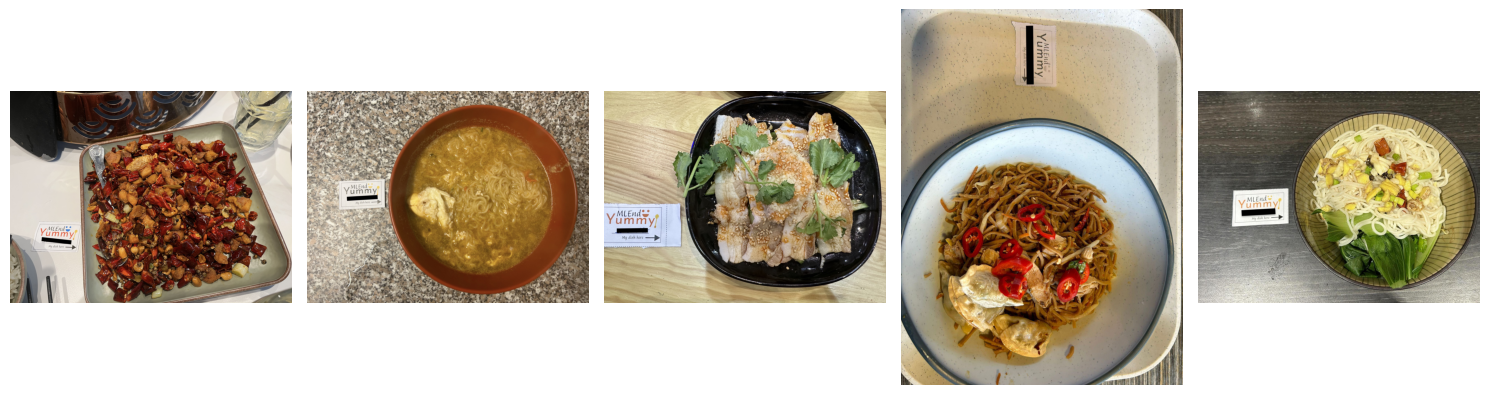

Indian


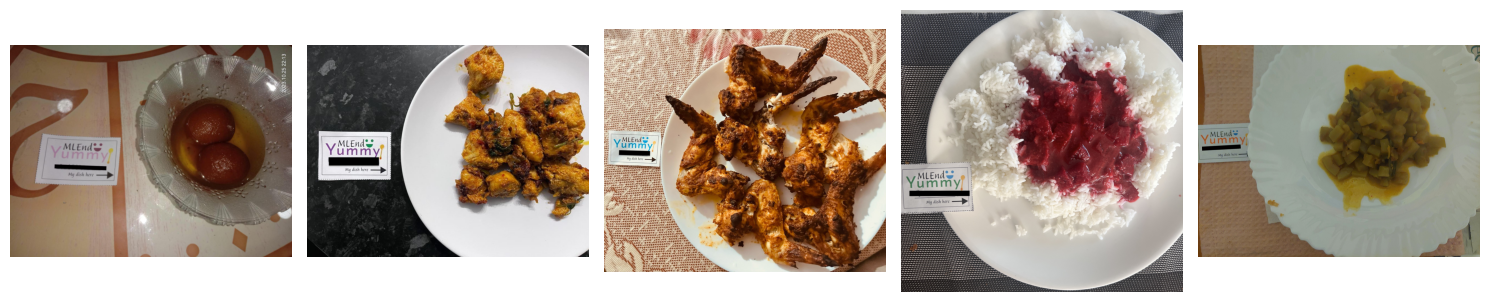

<Figure size 640x480 with 0 Axes>

Italian


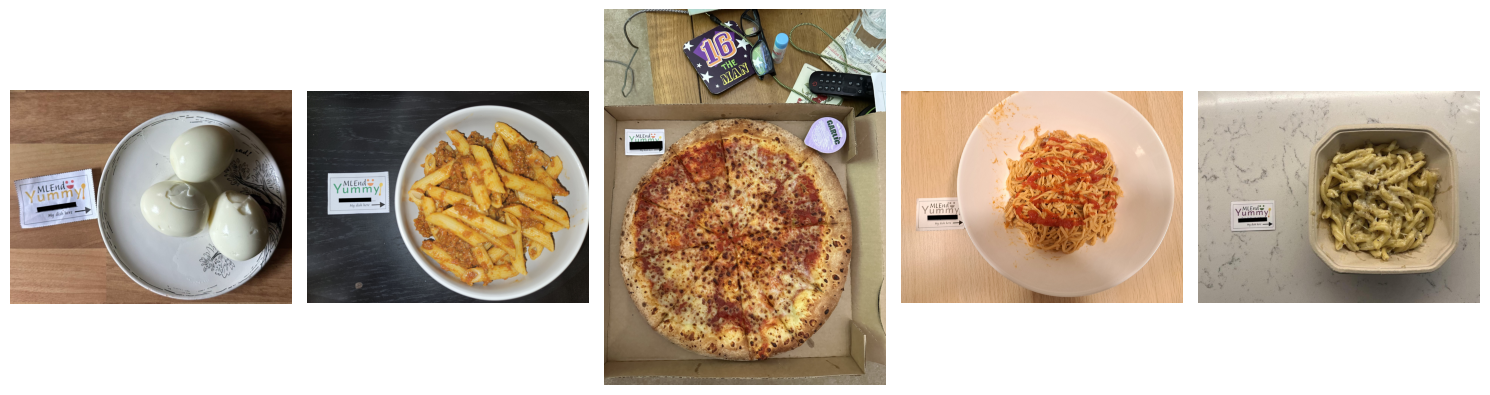

In [9]:
chinese_Img = np.array(X_train_paths)[Y_train==2]
indian_Img = np.array(X_train_paths)[Y_train==3]
italian_Img = np.array(X_train_paths)[Y_train==4]

print('Chinese')
plt.figure(figsize=(15,5))
for k,file in enumerate(chinese_Img[0:5]):
  I = plt.imread(file)
  N,M,C = I.shape
  # print(f"N = {N}")
  # print(f"M = {M}")
  # print(f"C = {C}")
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

plt.tight_layout()
plt.show()

print('Indian')
plt.figure(figsize=(15,5))
for k,file in enumerate(indian_Img[0:5]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

print('Italian')
plt.figure(figsize=(15,5))
for k,file in enumerate(italian_Img[0:5]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

plt.tight_layout()
plt.show()

### Machine Learning Pipeline

#### Input:
- **Data Collection:**
    - 1732 labeled images of Indian, Chinese, and Italian cuisines obtained from the MLEnd dataset using the `download_yumll` function. These images are stored in a directory along with details in a CSV file.
  
#### Stages:

1. **Data Preprocessing:**
    - **Splitting Data:** Divide images into train and test sets based on a 0.7:0.3 ratio from the CSV file.
    - **Standardizing Image Size:**
        - Make images square-shaped by padding 0-valued pixels in the shorter dimension, creating uniformly square images in training and testing datasets.
        - Resize images to 200x200 for uniformity and reduced computation.
   
2. **Feature Engineering:**
    - **Feature Extraction:**
        - Extract the yellow component of the images.
        - Compute Gray-Level Co-occurrence Matrix (GLCM) features.
        - Apply Gabor filters for feature extraction.
        - Combine extracted features into a single feature vector for each image.

3. **Model Selection:**
    - **Initializing Model:**
        - Initialize model: Logistic Regression
4. **Model Training:**
    - **Training Models:**
        - Train the initialized model using the generated feature vectors and corresponding labels.

5. **Model Evaluation:**
    - **Assessing Model Performance:**
        - Calculate training accuracy scores for all the model.
        - Calculate testing accuracy.
        - Obtain confusion matrices and assess misclassification scores for all three models.
accuracy scores for comparison.

# 4 Transformation stage

Describe any transformations, such as feature extraction. Identify input and output. Explain why you have chosen this transformation stage.

We are performing two kinds of transformation to our data.
1. Image preprocessing
2. Feature Extraction

### Image Preprocessing:

1.  **Splitting the Images into Train and Test Sets**:
    
    *   The dataset of 100 labeled images (rice or chips) is divided into two subsets:
        *   **Train Set**: Data used for training the machine learnidelsng mo Cont600ns 70 isdels.
        *   **Test Set**: Independent data used for evaluating the trainedperfor Con150ins 29 smance.
2.  **Padding Images to Create a Square Shape**:
    
    *   Since the original images have different sizes, they are padded to transform them into a uniform square shape.
    *   Padding ensures that each image has consistent dimensions, which is often necessary for certain image processing tasks.
3.  **Resizing Images to 200x200 Pixels**:
    
    *   After padding, the images are resized to a standard size of 200x200 pixels.
    *   Resizing helps in standardizing the input size for the subsequent feature extraction steps and m Resizing also reduces computation due to the reduc ed pixel countthe machine learning models later on.



### Feature Engineering:

1. **Extracting Features**:

   a. **Obtaining the Yellow Component of the Images**:
   - Extracting specific color components (in this case, yellow) from the images. This could involve techniques like color space conversion to extract the yellow channel or extracting pixels that fall within a certain range of yellow in RGB or other color spaces.

   b. **Computing GLCM (Gray-Level Co-occurrence Matrix) Features**:
   - GLCM involves analyzing the spatial relationships between pixel intensities in an image to derive texture information, including properties like contrast, energy, homogeneity, correlation, and entropy.

   c. **Applying Gabor Filters for Feature Extraction**:
   - Gabor filters are used for capturing texture information at different scales and orientations in an image.
   - They convolve an image with a set of Gabor kernels (sinusoidal waveforms modulated by Gaussian functions) to highlight different frequency and orientation components.
   - The response of these filters yields information about texture patterns present in different parts of the image.
   
2. **Combining Extracted Features into a Single Feature Vector**:
   - Each image's features extracted from the yellow component, GLCM, and Gabor filters are combined into a single feature vector.
   - This comprehensive feature vector represents the amalgamation of different aspects (color, texture, etc.) of the image captured through various feature extraction techniques.
e learning models later on.

### What is GLCM?
- **Definition**: GLCM represents the joint probability distribution of pixel pairs at a specified spatial relationship (offset) within an image. It describes how often different combinations of pixel intensity values occur in relation to each other at given positions.
- **Texture Information**: GLCM is particularly useful for capturing texture information such as smoothness, roughness, directionality, and patterns within an image.

### Computation Process of GLCM:
1. **Defining Spatial Relationships (Offsets)**:
   - GLCM calculation involves defining a specific spatial relationship or distance between pixels, known as the offset or displacement.
   - Common offsets include horizontal, vertical, and diagonal directions.
2. **Creating the Co-occurrence Matrix**:
   - For each pixel in the image, its relationship with its neighboring pixel(s) at the defined offset is examined.
   - The co-occurrence matrix is constructed by counting the occurrences of different pairs of pixel intensity values (gray levels) at the specified spatial offset.
3. **Statistical Properties from GLCM**:
   - From the computed GLCM, various statistical properties can be derived. Common properties include:
     - **Contrast**: Measures the local variations in the image.
     - **Energy (or Angular Second Moment)**: Represents image homogeneity.
     - **Homogeneity**: Reflects the closeness of the distribution of elements in the GLCM to the GLCM diagonal.
     - **Correlation**: Indicates the linear dependency of gray levels in the GLCM.
     - **Entropy**: Measures the randomness or disorder within the image texture.
4. **Feature Extraction from GLCM**:
   - After computing the GLCM and its associated statistical properties, these properties are often used as features for machine learning models.
   - These features can be concatenated with other extracted features to create a comprehensive feature vector representing the image.
 image texture.


### Gabor Filters in Image Processing:

Gabor filters are mathematical functions widely used in image processing and computer vision for texture analysis and feature extraction. They possess the following characteristics:

1. **Wavelet-Like Function**:
   - Gabor filters are complex sinusoidal waveforms modulated by a Gaussian function in both spatial and frequency domains.
   - They analyze the frequency content of an image through sinusoidal components and control spatial extent and smoothness via Gaussian components.

2. **Tunable Parameters**:
   - Gabor filters can be fine-tuned using parameters such as:
     - **Orientation**: Dictates the filter's sensitivity to texture orientations.
     - **Frequency**: Manages the number of oscillations within the filter, useful for detecting fine or coarse textures.
     - **Spatial Aspect Ratio**: Controls the filter's shape and coverage on the image.

3. **Texture Analysis**:
   - Applying Gabor filters to an image involves convolving the image with these filters at various scales and orientations.
   - Each Gabor filter responds optimally to a particular frequency and orientation, highlighting texture patterns that match its characteristics.
   - These filters can capture edges, corners, stripes, and other texture patterns present in an image.l components.

4. **Applications in Food Image Classification**:
   - Helps distinguish textures of grains, vegetables, snacks, or processed foods (e.g., chips) based on unique patterns present.
  
### Advantages of Gabor Filters for Food Image Classification:

- **Texture Sensitivity**: Highly sensitive to texture variations, capturing fine details and complex patterns in food images.
  
- **Rotation and Scale Invariance**: Adjustable to different orientations and scales, ensuring effectiveness irrespective of texture orientation or size.

- **Feature Diversity**: Provides diverse features capturing different texture orientations and frequencies, enriching feature representation for mactexture characterization.


In [10]:
#Making images square and resizing images
def make_it_square(I, pad=0):
  N,M,C = I.shape
  if N>M:
    Is = [np.pad(I[:,:,i], [(0,0),(0, N-M)], 'constant', constant_values=pad) for i in range(C)]
  else:
    Is = [np.pad(I[:,:,i], [(0, M-N),(0,0)], 'constant', constant_values=pad) for i in range(C)]

  return np.array(Is).transpose([1,2,0])

#Applying the square and resize functions on the training and testing set
def resize_img(I,size=[100,100]):
  N,M,C = I.shape
  Ir = [sp.core.processing.resize(I[:,:,i],size) for i in range(C)]
  return np.array(Ir).transpose([1,2,0])

X_train = []
for k,file in enumerate(X_train_paths):
  sp.utils.ProgBar_JL(k,len(X_train_paths),L=50,color='blue')
  I = plt.imread(file)
  I = make_it_square(I, pad=0)
  I = resize_img(I,size=[200,200])
  X_train.append(I)


X_test = []
for k,file in enumerate(X_test_paths):
  sp.utils.ProgBar_JL(k,len(X_test_paths),L=50,color='blue')
  I = plt.imread(file)
  I = make_it_square(I, pad=0)
  I = resize_img(I,size=[200,200])
  X_test.append(I)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_train.shape, X_test.shape

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|603\603|
Done!
100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|153\153|
Done!


((603, 200, 200, 3), (153, 200, 200, 3))

In [49]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train.shape, X_test.shape

((603, 200, 200, 3), (153, 200, 200, 3))

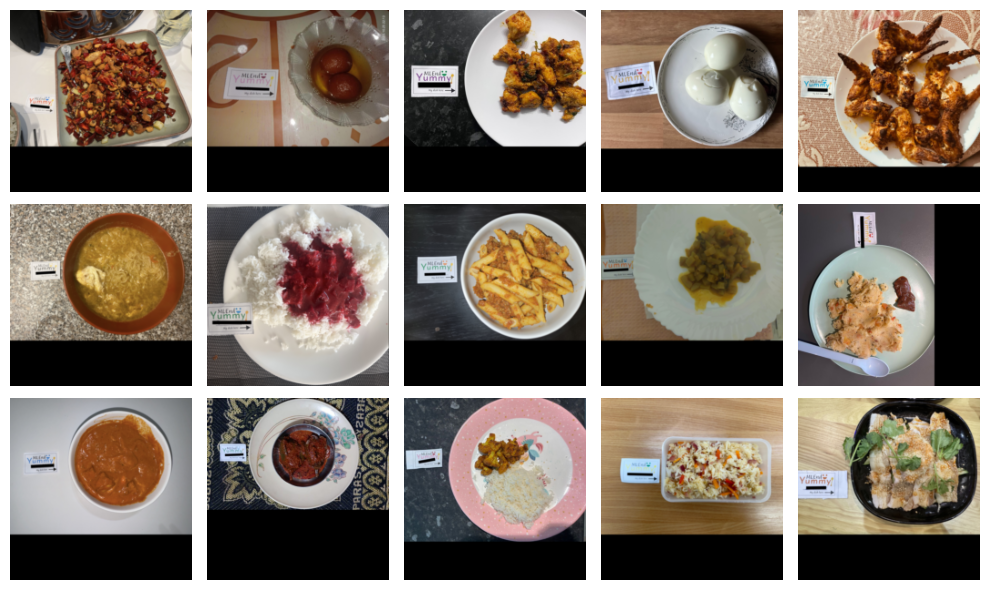

In [50]:
#Plotting preprocessed images - we can see the images are all of the same shape and size now.
plt.figure(figsize=(10,6))
for k,I in enumerate(X_train):
  plt.subplot(3,5,k+1)
  plt.imshow(I)
  plt.axis('off')
  k+=1
  if k>=15:break
plt.tight_layout()
plt.show()

In [12]:
#Feature Extraction

from skimage.feature import ORB
from skimage.feature import graycomatrix, graycoprops
from skimage.feature import hog
import cv2
from skimage.transform import resize
import numpy as np
from sklearn.preprocessing import StandardScaler

#Yellow_component feature extraction
def get_yellow_component(I,t1=27, t2=33):
  Ihsv = (rgb2hsv(I)*255).astype('uint8')
  mask = (Ihsv[:,:,0]<t2)*(Ihsv[:,:,0]>t1)
  Ypx = mask.sum()
  return Ypx

#GLCM feature extraction
def GMLC_features(I):
  Ig = (rgb2gray(I)*255).astype('uint8')
  glcm = graycomatrix(Ig, distances=[10], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi], levels=256,
                        symmetric=True, normed=True)
  f1 = graycoprops(glcm, 'dissimilarity')[0, 0]
  f2 = graycoprops(glcm, 'correlation')[0, 0]
  f3 = graycoprops(glcm, 'energy')[0, 0]
  return f1,f2,f3

#Gabor feature extraction
def Gabor_features(I):
    I = np.float32(I)
    gray_img = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY)
    gray_img = gray_img.astype(np.float32) / 255.0  # Normalize the image
    
    # Convert the image to 8-bit unsigned integer
    gray_img_uint8 = (gray_img * 255).astype(np.uint8)
    
    # Define the range of orientations and frequencies for Gabor filters
    num_orientations = 8
    num_frequencies = 8
    orientations = np.arange(0, np.pi, np.pi / num_orientations)
    frequencies = np.arange(0.2, 0.8, 0.1)
    
    # Initialize the feature vector to store Gabor filter responses
    feature_vector = []
    
    for freq in frequencies:
        for theta in orientations:
            # Create Gabor filter kernel
            kernel = cv2.getGaborKernel((9, 9), sigma=4.0, theta=theta, lambd=10.0 * freq, gamma=0.5, psi=0, ktype=cv2.CV_32F)
            
            # Apply Gabor filter to the image
            filtered_img = cv2.filter2D(gray_img, cv2.CV_32F, kernel)
            
            # Calculate mean and standard deviation of the filtered image as features
            mean = np.mean(filtered_img)
            std_dev = np.std(filtered_img)
            
            # Append the features to the feature vector
            feature_vector.extend([mean, std_dev])
    
    return feature_vector


In [13]:
#Call the feature extraction functions for each image in the training and test set and return one consolidated feature vector with all features appended

X_train_f = []
for k, I in enumerate(X_train):
  f1 = get_yellow_component(I)
  f2,f3,f4 = GMLC_features(I)
  gabor_features = Gabor_features(I)
  X_train_f.append([f1,f2,f3,f4] + gabor_features)

X_test_f = []
for k, I in enumerate(X_test):
  f1 = get_yellow_component(I)
  f2,f3,f4 = GMLC_features(I)
  gabor_features = Gabor_features(I)
  X_test_f.append([f1,f2,f3,f4] + gabor_features)

X_train_f = np.array(X_train_f)
X_test_f = np.array(X_test_f)
print(X_test_f.shape)


#Normalisation
MEAN = X_train_f.mean(0)
SD = X_train_f.std(0)
X_train_fn = (X_train_f - MEAN)/SD
X_test_fn = (X_test_f - MEAN)/SD

(153, 116)


# 5 Modelling

Describe the ML model(s) that you will build. Explain why you have chosen them.
For this problem we are using a linear SVM model

### Advantages of Random Forest Classifier for Food Image Classification with Multiple Classes:

1. **Handling Multi-Class Classification**:
   - Random Forest is capable of effectively handling multi-class classification problems, making it suitable for categorizing food images into multiple food categories.

2. **Ensemble Learning**:
   - As an ensemble method, Random Forest constructs multiple decision trees during training, resulting in improved accuracy and robustness compared to individual decision trees. This is beneficial for achieving better classification across various food classes.

3. **Feature Importance Analysis**:
   - Provides insights into feature importance, aiding in understanding which image features (extracted from food images) are most influential in distinguishing between different food classes.

4. **Handling High-Dimensional Data**:
   - Capable of handling high-dimensional feature spaces, which is common in image classification tasks where feature extraction techniques like GLCM and LBP generate numerous features.

5. **Robustness to Noisy Data**:
   - Random Forest tends to be robust against noise and variations present in food images due to different backgrounds, lighting conditions, or angles.

6. **Reduced Overfitting**:
   - By constructing multiple decision trees and considering subsets of features for each tree, Random Forest can mitigate overfitting issues, leading to better generalization to new and unseen food images.

7. **Simplicity in Implementation and Tuning**:
   - Relatively simple to implement and less sensitive to hyperparameters compared to some complex models, making it easier to tune and utilize effectively in practice.

It's important to note that while Random Forest offers these advantages, the performance of any machine learning model depends on various factors related to dataset characteristics, feature extraction, and problem-specific considerations.
tions are applied.


# 6 Methodology

Describe how you will train and validate your models, how model performance is assesssed (i.e. accuracy, confusion matrix, etc)


1. **Accuracy**:
    - **Calculation**: Calculate the accuracy of each model by measuring the proportion of correctly classified instances (rice or chips) out of the total instances in the test set.
    - **Interpretation**: Accuracy provides an overall measure of how often the model predicts the correct class and is useful for understanding the model's general performance.

2. **Confusion Matrix**:
    - **Calculation**: Construct a confusion matrix for each model using the predictions on the test set.
    - **Interpretation**: The confusion matrix provides detailed information about the model's performance, displaying the counts of true positive (TP), true negative (TN), false positive (FP), and false negative (FN) predictions.
    - **Derived Metrics**:
        - **Precision**: Proportion of correctly predicted positive instances (rice) out of the total predicted positive instances.
        - **Recall (Sensitivity)**: Proportion of correctly predicted positive instances out of the actual positive instances.
        - **F1-score**: Harmonic mean of precision and recall, useful when dealing with imbalancenegative rate).

By using accuracy and confusion matrix-based metrics like precision, recall, and F1-score, you can thoroughly assess the performance of each model in classifying food images into rice or chips, gaining insights into their strengths and weaknesses in distinguishing between the two classes.


Training Accuracy:	 0.5953565505804311
Test  Accuracy:	 0.40522875816993464


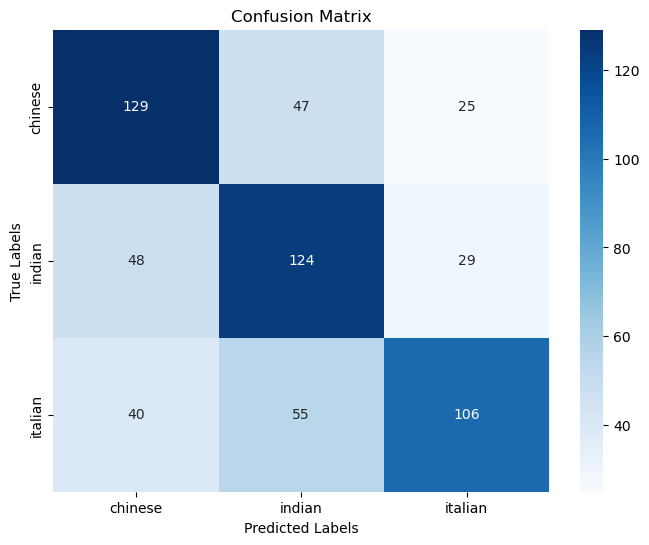

Classification Report:
               precision    recall  f1-score   support

           2       0.46      0.51      0.48        51
           3       0.40      0.45      0.43        51
           4       0.33      0.25      0.29        51

    accuracy                           0.41       153
   macro avg       0.40      0.41      0.40       153
weighted avg       0.40      0.41      0.40       153



In [16]:
model = RandomForestClassifier(n_estimators=5,max_depth=4)
model.fit(X_train_fn, Y_train)

ytp = model.predict(X_train_fn)
ysp = model.predict(X_test_fn)

train_accuracy = np.mean(ytp==Y_train)
test_accuracy  = np.mean(ysp==Y_test)

print('Training Accuracy:\t',train_accuracy)
print('Test  Accuracy:\t',test_accuracy)

conf_matrix = confusion_matrix(Y_train, ytp)
classes = ['chinese', 'indian', 'italian']
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', 
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# Calculate F1 score, precision, and recall
class_report = classification_report(Y_test, ysp)
print('Classification Report:\n', class_report)

# 8 Results:

- **Training Accuracy:*59.5343%
- **Test Accuracy:40.52.846### Interpretation of the Classification Report:

1. **Precision**:
   - For class 2 (presumably one category of food), precision is 0.46. It indicates that among the instances predicted as class 2, 46% were actually correctly classified as class 2.
   - For class 3 and class 4, the precisions are 0.40 and 0.33, respectively.

2. **Recall**:
   - For class 2, the recall (sensitivity) is 0.51. It means that among all actual instances of class 2, the model correctly identified 51% of them.
   - Class 3 and class 4 have recalls of 0.45 and 0.25, respectively.

3. **F1-Score**:
   - F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall. The F1-scores for classes 2, 3, and 4 are 0.48, 0.43, and 0.29, respectively.

4. **Support**:
   - The number of instances (support) for each class is 51.

5. **Accuracy**:
   - Overall accuracy of the model on the dataset is 0.41 (41%).

6. **Macro Average**:
   - The macro average of precision, recall, and F1-score calculates the average of these metrics across all classes without considering class imbalance. The macro average precision, recall, and F1-score are around 0.40.

7. **Weighted Average**:
   - The weighted average of precision, recall, and F1-score calculates the metrics weighted by the number of true instances for each class. The weighted average precision, recall, and F1-score are also around 0.40.

### Summary:

- The model appears to have some difficulty distinguishing between the classes (2, 3, and 4), as indicated by relatively low precision, recall, and F1-scores.
- Class 2 seems to have slightly better performance compared to classes 3 and 4 based on precision, recall, and F1-score.
- The overall accuracy of the model is 41%, suggesting that the model's performance in correctly predicting the classes is relatively modest.
  
This report suggests that the model might struggle to differentiate between these particular classes, and further analysis or improvements might be necessary to enhance its classification performance for these food categories.
 capability.
y.334

## 9 Conclusions
### Strategies to Improve Model Performance for Food Image Classification:

1. **Feature Engineering**:
   - **Explore Additional Features**: Investigate if there are other relevant features related to food images that could enhance classification accuracy.
   - **Feature Scaling/Normalization**: Ensure all features are on a similar scale to prevent biases towards certain features during model training.

2. **Data Preprocessing**:
   - **Data Augmentation**: Generate additional training samples by applying transformations like rotation, flipping, or adding noise to improve model generalization.
   - **Balancing Classes**: Address class imbalance by oversampling minority classes or using techniques like Synthetic Minority Over-sampling Technique (SMOTE).

3. **Model Improvement**:
   - **Hyperparameter Tuning**: Optimize hyperparameters (like tree depth, number of trees, etc.) using techniques such as grid search or random search.
   - **Ensemble Methods**: Experiment with other ensemble models or boosting techniques (e.g., Gradient Boosting, XGBoost) to potentially improve classification performance.

4. **Feature Selection**:
   - **Select Important Features**: Use techniques like Recursive Feature Elimination (RFE) or feature importance from Random Forest to focus on the most relevant features for classification.

5. **Model Evaluation and Validation**:
   - **Cross-Validation**: Perform robust evaluation using k-fold cross-validation to ensure the model's performance stability and generalizability.
   - **Validation Set**: Use a separate validation set to fine-tune model parameters and avoid overfitting.

6. **Utilize Deep Learning**:
   - **Convolutional Neural Networks (CNNs)**: Explore CNN architectures tailored for image classification, allowing the model features from the images directly.
7. **Error Analysis and Feedback Loop**:
   - **Error Analysis**: Analyze misclassified instances to understand common patterns or causes of misclassification, and refine the model accordingly.
   - **Model Iteration**: Implement feedback loops to continuously improve the model based on insights gaon to prevent overfitting.
   -
and robustness.
